In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pylab import mpl, plt
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'arial'
np.random.seed(123)
np.set_printoptions(suppress=True, precision=4)
%matplotlib inline


import seaborn as sns
sns.set_style("whitegrid")
#plt.style.use('ggplot')

import custom_functions as cf
from xgboost import XGBClassifier

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, roc_curve

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


from imblearn.over_sampling import SMOTE
from collections import Counter

Using TensorFlow backend.


## EDA

In [3]:
failed_banks = pd.read_csv('data/failed_banks_dataset.csv')
failed_banks['Date'] = pd.to_datetime(failed_banks['Closing Date'])
failed_banks['Year_failed'] = failed_banks['Date'].dt.year
failed_banks['Quarter_failed'] = failed_banks['Date'].dt.quarter
#len(failed_banks.loc[(failed_banks.Year_failed == 2013) & (failed_banks.Quarter_failed == 1)])

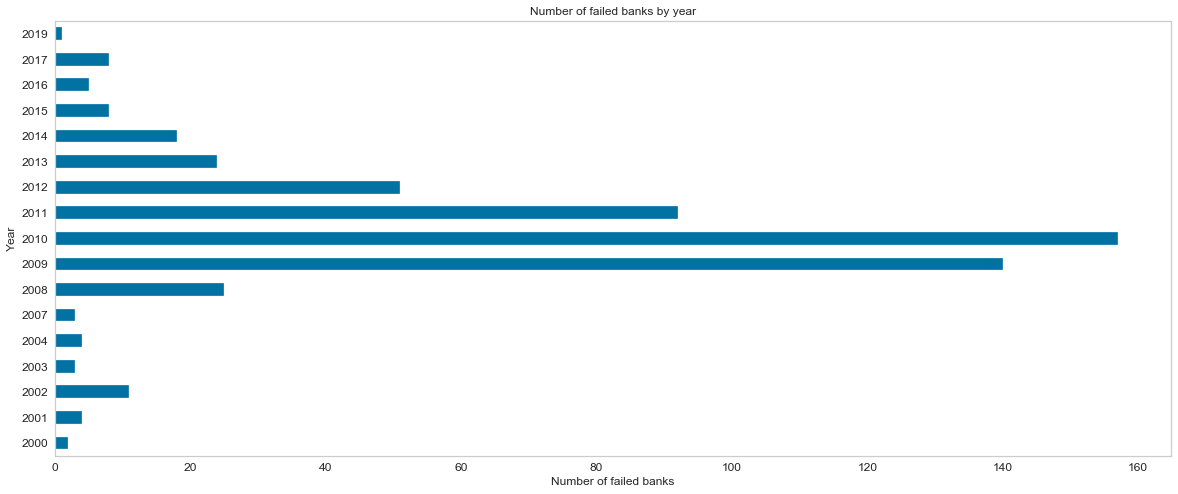

In [4]:
ax = failed_banks.groupby(failed_banks.Date.dt.year)['Bank Name'].count().plot(
    kind='barh', title ="Number of failed banks by year", color='b', figsize=(20, 8), legend=False, fontsize=12)
ax.grid()
ax.set_xlabel("Number of failed banks", fontsize=12)
ax.set_ylabel("Year", fontsize=12)
plt.show()

In [5]:
banks_data = {'2009Q4': {'Actual failed': 41, 'True positive': 0, 'False positive': 0},
              '2010Q1': {'Actual failed': 45, 'True positive': 0, 'False positive': 0},
              '2010Q2': {'Actual failed': 41, 'True positive': 0, 'False positive': 0},
              '2010Q3': {'Actual failed': 30, 'True positive': 0, 'False positive': 0},
              '2010Q4': {'Actual failed': 26, 'True positive': 24, 'False positive': 120},
              '2011Q1': {'Actual failed': 22, 'True positive': 22, 'False positive': 100},
              '2011Q2': {'Actual failed': 26, 'True positive': 26, 'False positive': 90},
              '2011Q3': {'Actual failed': 18, 'True positive': 18, 'False positive': 120},
              '2011Q4': {'Actual failed': 16, 'True positive': 16, 'False positive': 120},
              '2012Q1': {'Actual failed': 15, 'True positive': 15, 'False positive': 120},
              '2012Q2': {'Actual failed': 12, 'True positive': 12, 'False positive': 120},
              '2012Q3': {'Actual failed': 8, 'True positive': 8, 'False positive': 123},
              '2012Q4': {'Actual failed': 4, 'True positive': 4, 'False positive': 120}
             }

In [7]:
df = pd.DataFrame.from_dict(banks_data, orient='index')
#df['Assets lost'] = [100, 120, 200, 400, 1000, 5000, 10000, 12000]

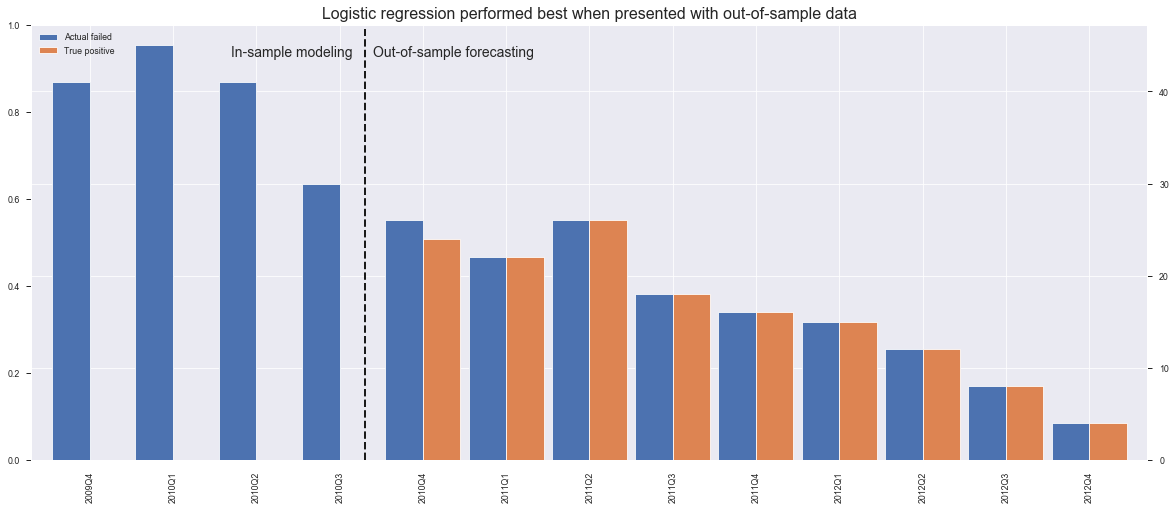

In [8]:
sns.set(font_scale=1)
sns.set_context("paper")
fig, ax1 = plt.subplots(sharex=True, figsize=(20, 8))
ax2 = ax1.twinx()
df[['Actual failed', 'True positive']].plot(ax=ax1, kind='bar', width=0.9).legend(loc='upper left')
#df['Assets lost'].plot(ax=ax2, kind='line', linewidth=5, style='r', marker='d').legend(loc='upper right')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
plt.axvline(x=3.3, ymin=0, ymax = 0.99, linewidth=2, color='k', linestyle='--')
ax1.text(x= 1.7, y=45, s='In-sample modeling', fontsize=14, verticalalignment='top')
ax1.text(x= 3.4, y=45, s='Out-of-sample forecasting', fontsize=14, verticalalignment='top')
ax2.grid(False)
plt.title('Logistic regression performed best when presented with out-of-sample data', fontsize=16)
plt.show()


## Load and inspect data set from 2010-Q3

In [9]:
camel_insample = pd.read_csv('data/camel_data_after2010Q3.csv', index_col = 0)

In [10]:
camel_model_set = camel_insample.dropna()

In [11]:
X = camel_model_set.drop(columns=['AsOfDate', 'Target'])
# Standardizing the features for PCS
X_pca_std = StandardScaler().fit_transform(X)

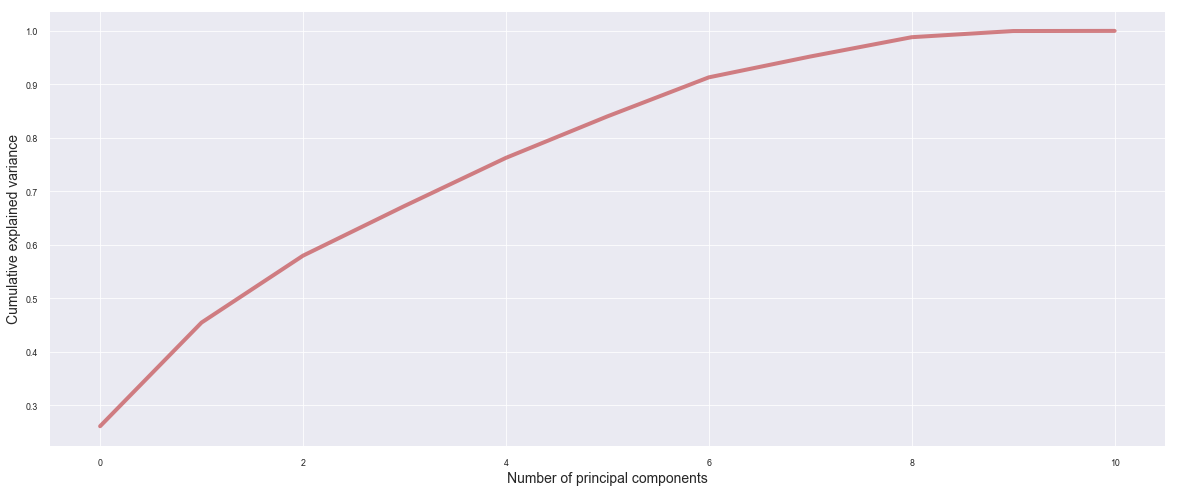

In [20]:
# Run PCA and plot variance explained by CAMELS dimensions (feautures)
pca = PCA().fit(X_pca_std)
plt.figure(figsize=(20,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), alpha=0.7, linewidth=4, color='r')
plt.xlabel('Number of principal components', fontsize=14)
plt.ylabel('Cumulative explained variance', fontsize=14)

In [163]:
# TODO: redo to show all on one plot
# for col in camel_model_set.drop(columns=['AsOfDate', 'Target']).columns:
#     camel_model_set[col].hist(by=camel_model_set['Target'],  bins=20, figsize=(8,16), alpha=0.7, color='r')
#     plt.suptitle(col)
# plt.show()

## Over-sampling with SMOTE

In [21]:
y = camel_model_set['Target']
X = camel_model_set.drop(['Target', 'AsOfDate'], axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [24]:
print('Original dataset shape %s' % Counter(y_train))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_train_std_res, y_train_res = sm.fit_resample(X_train_std, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

Original dataset shape Counter({0: 5501, 1: 110})
Resampled dataset shape Counter({0: 5501, 1: 5501})


## Investigating importance of CAMELS features with Decision Trees

In [25]:
# TODO: introduction to CAMELS risk dimensions    


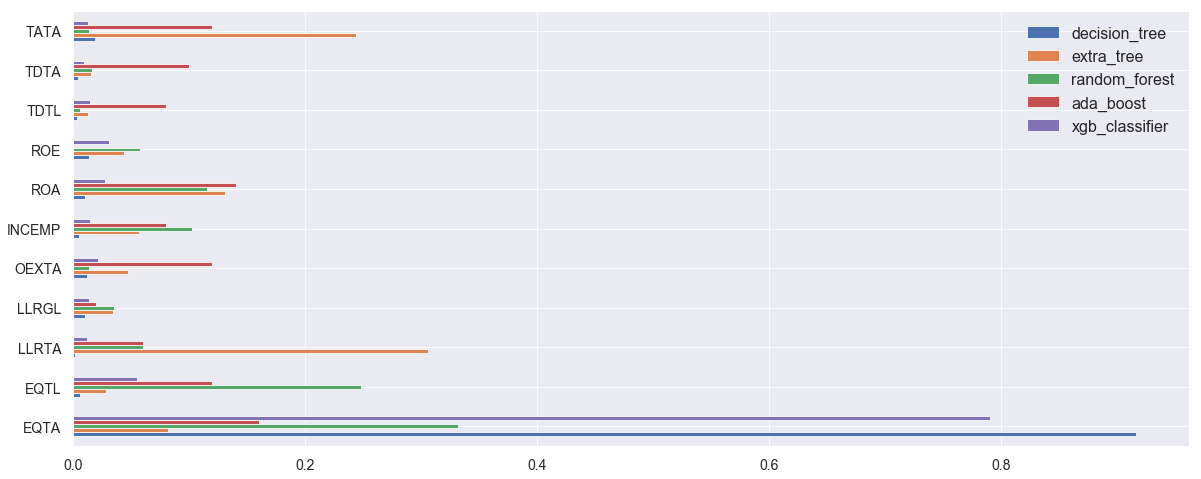

In [26]:
classifiers = {'decision_tree' : DecisionTreeClassifier(),
         'extra_tree' : ExtraTreeClassifier(),
         'random_forest' : RandomForestClassifier(n_estimators=100),
         'ada_boost' : AdaBoostClassifier(),
         'xgb_classifier' : XGBClassifier()}

features_from_classifiers = []
for classifier in classifiers:
    features_from_classifiers.append(classifiers[classifier].fit(X_train_std_res, y_train_res).feature_importances_)

# TODO: add human readble CAMELS risk dimensions nammes'

features_df = pd.DataFrame(features_from_classifiers, classifiers, 
                           columns=camel_model_set.drop(columns=['AsOfDate', 'Target']).columns)
features_df.T.plot(kind='barh', figsize=(20, 8), fontsize=14)
plt.legend(fontsize=16)
plt.show()

## Traing various models and evaluating classification accuracy

In [27]:
models = {
    'logistic_reg' : LogisticRegression(C=1, solver='lbfgs'),
    'stochastic_gd' : SGDClassifier(),
    'gauss_nb' : GaussianNB(),
    'svm' : SVC(C=1, gamma='auto'),
    'decision_tree' : DecisionTreeClassifier(),
    'extra_tree' : ExtraTreeClassifier(),
    'random_forest' : RandomForestClassifier(n_estimators=100),
    'ada_boost' : AdaBoostClassifier(),
    'xgb_classifier' : XGBClassifier(),
    'dnn_classifier' : MLPClassifier(solver='lbfgs', activation='relu', alpha=1e-5 ,hidden_layer_sizes=2*[75])
}

accuracy = {}
precision_scores_is = {}
recall_scores_is = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_test_std)
    recall_scores_is[model] = recall_score(y_test, y_predicted).round(2)
    precision_scores_is[model] = precision_score(y_test, y_predicted).round(2)

In [28]:
recall_scores_is

{'logistic_reg': 0.93,
 'stochastic_gd': 0.96,
 'gauss_nb': 1.0,
 'svm': 0.85,
 'decision_tree': 0.63,
 'extra_tree': 0.67,
 'random_forest': 0.74,
 'ada_boost': 0.89,
 'xgb_classifier': 0.89,
 'dnn_classifier': 0.7}

In [29]:
precision_scores_is

{'logistic_reg': 0.4,
 'stochastic_gd': 0.41,
 'gauss_nb': 0.04,
 'svm': 0.45,
 'decision_tree': 0.45,
 'extra_tree': 0.33,
 'random_forest': 0.62,
 'ada_boost': 0.38,
 'xgb_classifier': 0.51,
 'dnn_classifier': 0.63}

### In-sample recall score is of most importance in predicting failed banks

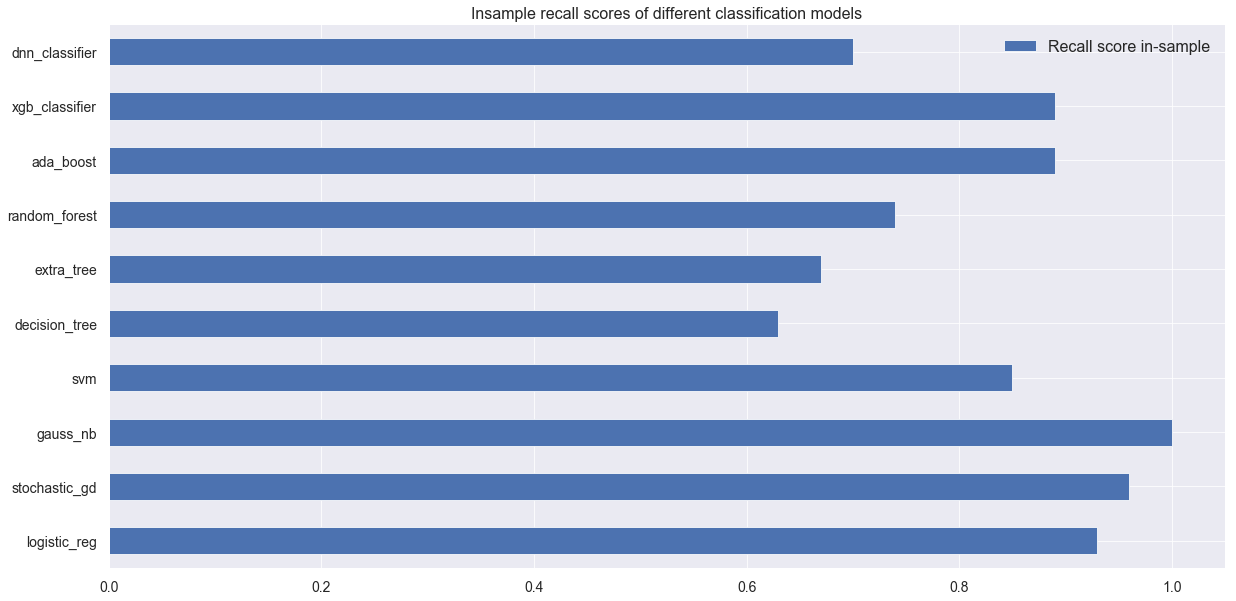

In [32]:
df = pd.DataFrame.from_dict(recall_scores_is, orient='index', columns=['Recall score in-sample'])
df.plot(kind='barh', figsize=(20, 10), fontsize=14)
plt.legend(fontsize=16)
plt.title("Insample recall scores of different classification models", fontsize=16)
plt.show()

## Validation on out-of-sample data 2010Q4 - 2012Q2

In [33]:
# checking the models out of sample for 2010 Q4
recalls_oos_df = pd.DataFrame()

In [34]:
camel_outofsample = pd.read_csv('data/camel_data_after2010Q4_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [35]:
y_oos_2010Q4 = camel_validation_set['Target']
X_oos_2010Q4 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2010Q4)
X_oos_std_2010Q4 = scaler.transform(X_oos_2010Q4)

In [36]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2010Q4)
    recall_scores_oos[model] = recall_score(y_oos_2010Q4, y_predicted).round(2)
recalls_oos_df = pd.DataFrame.from_dict(recall_scores_oos, orient='index', columns=['2010Q4'])

In [37]:
# checking the models out of sample for 2011 Q1

In [38]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q1_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [39]:
y_oos_2011Q1 = camel_validation_set['Target']
X_oos_2011Q1 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2011Q1)
X_oos_std_2011Q1 = scaler.transform(X_oos_2011Q1)

In [40]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q1)
    recall_scores_oos[model] = recall_score(y_oos_2011Q1, y_predicted).round(2)
recalls_oos_df['2011Q1'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [41]:
# checking the models out of sample for 2011 Q2

In [42]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q2_OOS.csv', index_col = 0)
camel_outofsample.replace([np.inf, -np.inf], 'NaN', inplace=True)
camel_validation_set = camel_outofsample.dropna()

In [43]:
len(camel_validation_set)

6689

In [44]:
y_oos_2011Q2 = camel_validation_set['Target']
X_oos_2011Q2 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)

In [45]:
X_oos_2011Q2.replace([np.inf, -np.inf], 'NaN', inplace=True)
X_oos_2011Q2 = X_oos_2011Q2.dropna()
len(X_oos_2011Q2)

6689

In [46]:
scaler = StandardScaler()
scaler.fit(X_oos_2011Q2)
X_oos_std_2011Q2 = scaler.transform(X_oos_2011Q2)

In [47]:
place_holder_df = pd.DataFrame(X_oos_std_2011Q2)
place_holder_df.fillna(value=0, inplace=True)
X_oos_std_2011Q2 = np.array(place_holder_df)

In [48]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q2)
    recall_scores_oos[model] = recall_score(y_oos_2011Q2, y_predicted).round(2)
recalls_oos_df['2011Q2'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [49]:
#Validation on 2011 Q3 data

In [50]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q3_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [51]:
y_oos_2011Q3 = camel_validation_set['Target']
X_oos_2011Q3 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2011Q3)
X_oos_std_2011Q3 = scaler.transform(X_oos_2011Q3)

In [52]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q3)
    recall_scores_oos[model] = recall_score(y_oos_2011Q3, y_predicted).round(2)
recalls_oos_df['2011Q3'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [53]:
# Validation on 2011 Q4

In [54]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q4_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [55]:
y_oos_2011Q4 = camel_validation_set['Target']
X_oos_2011Q4 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2011Q4)
X_oos_std_2011Q4 = scaler.transform(X_oos_2011Q4)

In [56]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q4)
    recall_scores_oos[model] = recall_score(y_oos_2011Q4, y_predicted).round(2)
recalls_oos_df['2011Q4'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [57]:
# Validation on 2012 Q1

In [58]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q1_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [59]:
y_oos_2012Q1 = camel_validation_set['Target']
X_oos_2012Q1 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q1)
X_oos_std_2012Q1 = scaler.transform(X_oos_2012Q1)

In [60]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q1)
    recall_scores_oos[model] = recall_score(y_oos_2012Q1, y_predicted).round(2)
recalls_oos_df['2012Q1'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [61]:
# Validation on 2012 Q2

In [62]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q2_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [63]:
y_oos_2012Q2 = camel_validation_set['Target']
X_oos_2012Q2 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q2)
X_oos_std_2012Q2 = scaler.transform(X_oos_2012Q2)

In [64]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q2)
    recall_scores_oos[model] = recall_score(y_oos_2012Q2, y_predicted).round(2)
recalls_oos_df['2012Q2'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [65]:
# Validation on 2012 Q3

In [66]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q3_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [67]:
y_oos_2012Q3 = camel_validation_set['Target']
X_oos_2012Q3 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q3)
X_oos_std_2012Q3 = scaler.transform(X_oos_2012Q3)

In [68]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q3)
    recall_scores_oos[model] = recall_score(y_oos_2012Q3, y_predicted).round(2)
recalls_oos_df['2012Q3'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [69]:
# Validation on 2012 Q4

In [70]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q4_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [71]:
y_oos_2012Q4 = camel_validation_set['Target']
X_oos_2012Q4 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q4)
X_oos_std_2012Q4 = scaler.transform(X_oos_2012Q4)

In [72]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q4)
    recall_scores_oos[model] = recall_score(y_oos_2012Q4, y_predicted).round(2)
recalls_oos_df['2012Q4'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

## Out-of-sample validation summary results

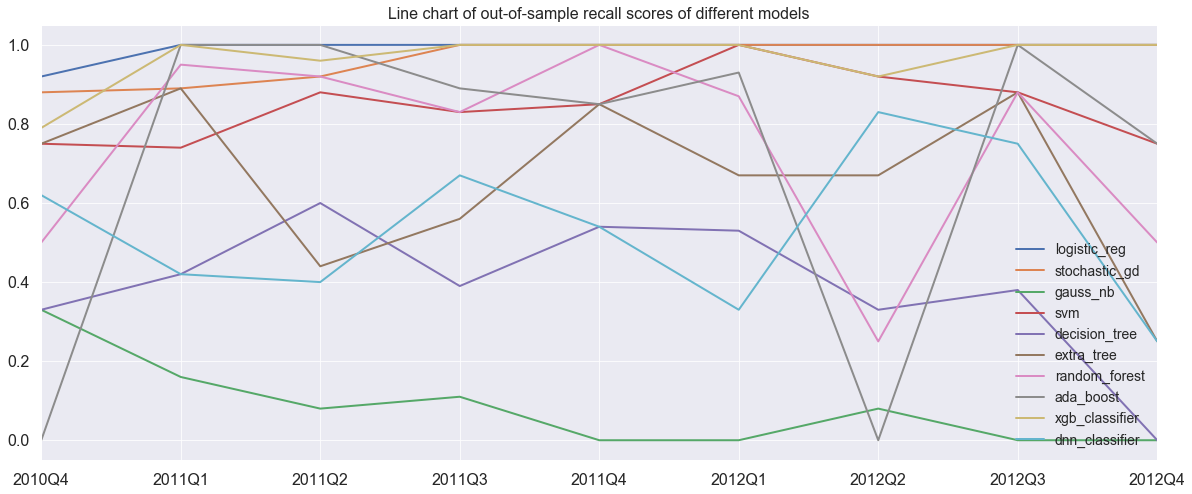

In [91]:
recalls_oos_df.T.plot(kind='line', figsize=(20,8), linewidth=2, fontsize=16).legend(loc='lower right', fontsize=14)
plt.title("Line chart of out-of-sample recall scores of different models", fontsize=16)
plt.show()

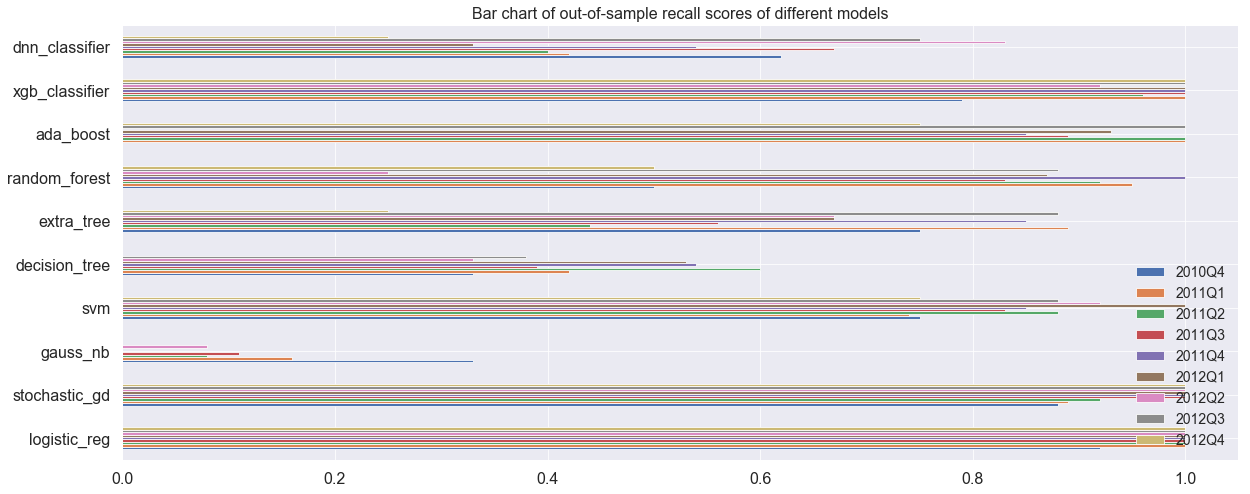

In [85]:
recalls_oos_df.plot(kind='barh', figsize=(20,8), fontsize=16).legend(loc='lower right', fontsize=14)
plt.title("Bar chart of out-of-sample recall scores of different models", fontsize=16)
plt.show()

In [16]:
# To get the value of precision we divide the total number of correctly classified positive examples 
# by the total number of predicted positive examples. 
# High Precision indicates an example labeled as positive is indeed positive (small number of FP).

# Recall can be defined as the ratio of the total number of correctly classified positive 
# examples divide to the total number of positive examples. 
# High Recall indicates the class is correctly recognized (small number of FN).

# High recall, low precision:This means that most of the positive examples are correctly recognized (low FN) 
# but there are a lot of false positives. Low recall, high precision:This shows that we miss a lot 
# of positive examples (high FN) but those we predict as positive are indeed positive (low FP)

cf.report_classification_results(y_oos, log_reg_res_pred)

Confusion Matrix :
[[6565   46]
 [  18    0]]
Accuracy Score : 0.9903454518026852
Report : 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6611
           1       0.00      0.00      0.00        18

    accuracy                           0.99      6629
   macro avg       0.50      0.50      0.50      6629
weighted avg       0.99      0.99      0.99      6629



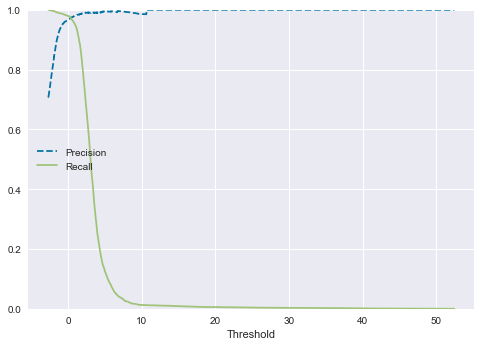

In [24]:
# Training
sgd_y_train_res_scores = cross_val_predict(sgd_clf_res, X_train_std_res, y_train_res, cv=3, method='decision_function')
sgd_train_precisions, sgd_train_recalls, sgd_train_thresholds = precision_recall_curve(y_train_res, sgd_y_train_res_scores)
cf.plot_precision_recall(sgd_train_precisions, sgd_train_recalls, sgd_train_thresholds)

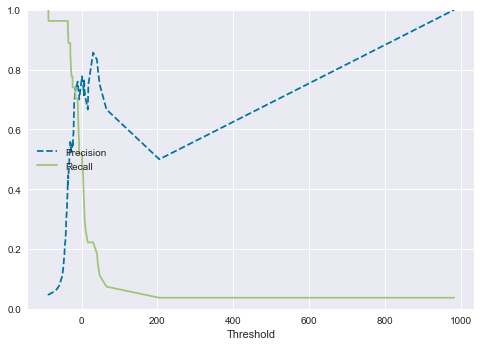

In [25]:
# Testing
sgd_y_test_res_scores = cross_val_predict(sgd_clf_res, X_test_std, y_test, cv=3, method='decision_function')
sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds = precision_recall_curve(y_test, sgd_y_test_res_scores)
cf.plot_precision_recall(sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds)

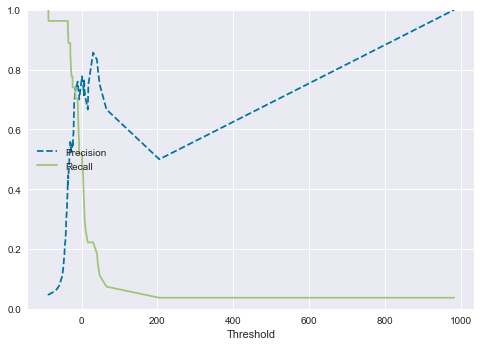

In [26]:
# Validation 
sgd_y_oos_res_scores = cross_val_predict(sgd_clf_res, X_oos, y_oos, cv=3, method='decision_function')
sgd_oos_precisions, sgd_oos_recalls, sgd_oos_thresholds = precision_recall_curve(y_oos, sgd_y_oos_res_scores)
cf.plot_precision_recall(sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds)

In [41]:
def plot_roc_curve(fpr, tpr, label=None):   
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Negatove Rate')

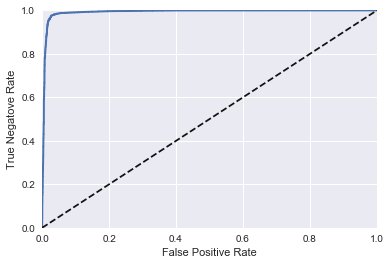

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_res, sgd_y_train_res_scores)
plot_roc_curve(fpr, tpr)